# Jane Street Market Prediction 
> Buy low, sell high. It sounds so easy….

- toc: true
- badges: true
- author: Austin Chen
- categories: [time series,stock]

In [ ]:
#hide

%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']

Writing conditional_cell_extension.py


In [ ]:
#hide
%reload_ext conditional_cell_extension

## Dependencies

In [ ]:
#hide
!pip install dabl > /dev/null
!pip install datatable > /dev/null

In [ ]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import dabl
import datatable as dt

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.0


In [ ]:
#hide
#@title Accelerator { run: "auto" }
DEVICE = 'GPU' #@param ["None", "'GPU'", "'TPU'"] {type:"raw", allow-input: true}

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [ ]:
#hide
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
                name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#collapse-hide
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [ ]:
#hide
%%run_if {GOOGLE}
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#hide
project_name = 'jane-street-market-prediction'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['train.csv',
 'working',
 '__init__.py',
 'competition.cpython-37m-x86_64-linux-gnu.so',
 'train.csv.zip',
 'example_sample_submission.csv',
 'features.csv',
 'example_test.csv.zip']

In [ ]:
#hide
!kaggle competitions download -c jane-street-market-prediction

  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 8.29kB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 28.4MB/s]
100% 2.60G/2.61G [00:26<00:00, 49.7MB/s]
100% 2.61G/2.61G [00:26<00:00, 106MB/s] 
  0% 0.00/108k [00:00<?, ?B/s]
100% 108k/108k [00:00<00:00, 15.2MB/s]
  0% 0.00/23.3k [00:00<?, ?B/s]
100% 23.3k/23.3k [00:00<00:00, 3.31MB/s]
 55% 9.00M/16.4M [00:00<00:00, 40.0MB/s]
100% 16.4M/16.4M [00:00<00:00, 54.6MB/s]


We can observe that the train.csv is large: `6GB` and it has `2390492` rows in the file.

In [ ]:
#hide_input
!wc -l {input_path}train.csv

2390492 /content/gdrive/MyDrive/kaggle/input/jane-street-market-prediction/train.csv


To speed things up here, let's use `datatable` to read the data, and then convert to a pandas dataframe.

In [ ]:
%%time
train_dt = dt.fread(f"{input_path}train.csv")

CPU times: user 28.6 s, sys: 5.02 s, total: 33.6 s
Wall time: 4min 41s


In [ ]:
%%time
train_df = train_dt.to_pandas()

CPU times: user 5.37 s, sys: 3.98 s, total: 9.35 s
Wall time: 7.07 s


# Exploration

## `resp`

2487

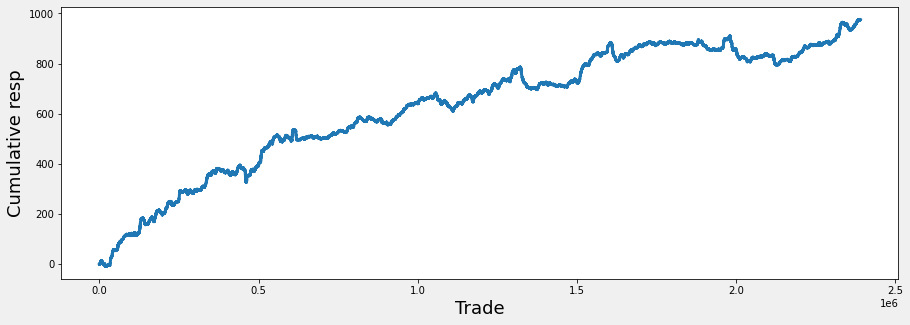

In [ ]:
#collapse-hide
fig,ax = plt.subplots(figsize=(15,5), facecolor="#F0F0F0")
balance = pd.Series(train_df['resp'].cumsum())
ax.set_xlabel("Trade", fontsize=18)
ax.set_ylabel("Cumulative resp", fontsize=18)
balance.plot(lw=3)
del balance
gc.collect()

as well as four [time horizons](https://www.investopedia.com/terms/t/timehorizon.asp)
> The longer the Time Horizon, the more aggressive, or riskier portfolio, ans investor can build. The shorter the Time Horizon, the more conservative, or less risky, the investor may want to adopt.

3382

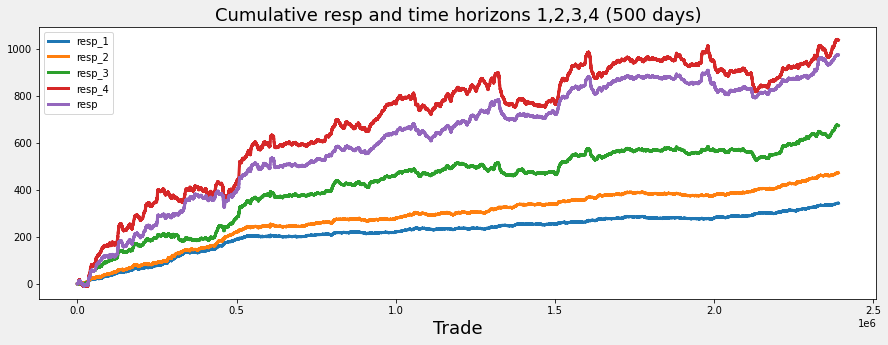

In [ ]:
#collapse-hide
fig,ax = plt.subplots(figsize=(15,5), facecolor="#F0F0F0")
resps = []
for colName, colData in train_df.iteritems():
    if ('resp' in colName):
        resps.append(colData.cumsum())
ax.set_xlabel("Trade", fontsize=18)
ax.set_title("Cumulative resp and time horizons 1,2,3,4 (500 days)", fontsize=18)
for r in resps: r.plot(lw=3)
plt.legend(loc="upper left")
del resps; gc.collect()

We can see that `resp` (in purple) most closely follows time horizon 4 (`resp_4` is the uppermost curve, in red).

In the notebook [Jane Street: time horizons and volatilities](https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities) by ***@pcarta***, if I understand correctly, by using maximum likelihood estimation it is calculated that if the time horizon ($T_j$) for `resp_1` (i.e. $T_1$ is 1, then
- $T_j$(resp_2) $\approx 1.4T_1$
- $T_j$(resp_3) $\approx 3.9T_1$
- $T_j$(resp_4) $\approx 11.1T_1$
where $T_1$ could correspond to 5 trading days.
Let's now plot a histogram of all of the `resp` values (here only shown for values between -0.05 and 0.05)


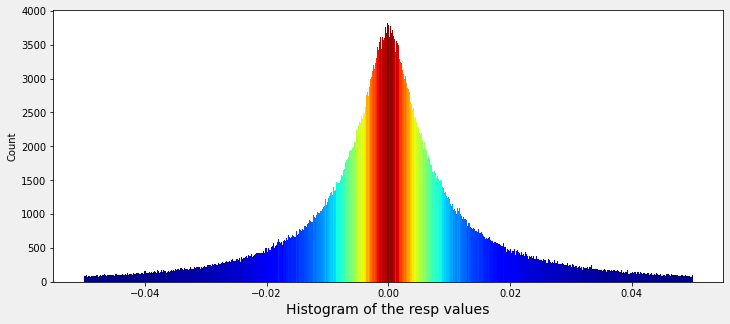

In [ ]:
#collapse-hide
fig,ax = plt.subplots(figsize=(12,5), facecolor="#F0F0F0")
sns.histplot(
    ax=ax,
    x=train_df['resp'], 
    bins=3000, 
    kde_kws={"clip":(-0.05,0.05)}, 
    binrange=(-0.05,0.05),
    color='darkcyan', 
    kde=False)
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show();
del values
gc.collect();

This distribution has very long tails

In [ ]:
#collapse-hide
print('The minimum value for resp is : %.5f' %  train_df['resp'].min())
print('The minimum value for resp is :  %.5f' % train_df['resp'].max())

The minimum value for resp is : -0.54938
The minimum value for resp is :  0.44846


Also calculate its' [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) of this distribution

In [ ]:
#collapse-hide
print("Skew of resp is:      %.2f" % train_df['resp'].skew() )
print("Kurtosis of resp is: %.2f"  % train_df['resp'].kurtosis() )

Skew of resp is:      0.10
Kurtosis of resp is: 17.36


## `weight`

> Each trade has an associated `weight` and `resp`, which together represents a return on the trade. Trades with `weight = 0` were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

In [ ]:
percent_zeros = (100/train_df.shape[0])*((train_df.weight.values == 0).sum())
print('Percentage of zero weights is: %i' % percent_zeros +"%")

Percentage of zero weights is: 0%


Let us see if there are any negative weights. A negative weight would be meaningless, but you never know.

In [ ]:
min_weight = train_df['weight'].min()
print('The minimum weight is: %.2f' % min_weight)

The minimum weight is: 0.01


An now to find the maximum weight used

In [ ]:
max_weight = train_df['weight'].max()
print('The maximum weight was: %.2f' % max_weight)

The maximum weight was: 167.29


which occured on day 446

In [ ]:
train_df[train_df['weight']==train_df['weight'].max()]

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
1322733,446,167.293716,0.000281,0.001213,0.00138,-0.000427,-0.001215,-1,-0.735754,-0.048433,-0.175366,-0.20698,0.150967,0.23681,0.035755,0.026819,-0.981118,-0.188376,0.069351,0.060235,-0.361906,0.09651,-0.789638,-0.582599,0.110738,0.114945,-0.455587,-0.844032,0.167681,0.177815,-0.3927,-0.804331,-0.527014,-0.93592,0.12584,0.160809,0.560677,1.263861,0.207275,0.252047,...,0.314832,1.342298,1.391578,0.900093,0.401429,-1.338859,0.420475,-0.509267,-1.194013,-0.420336,0.244751,-0.94019,0.320808,-0.237071,-1.781693,0.616443,0.392753,-0.484772,0.417847,-0.253349,-0.843852,-0.468821,0.262442,0.935519,0.288209,0.828683,0.438545,0.57467,-0.92586,0.948026,-1.094062,0.326287,-0.715126,1.490866,-1.111595,1.083793,-0.979801,0.913979,2097681,0


Let us take a look at a histogram of the non-zero weights



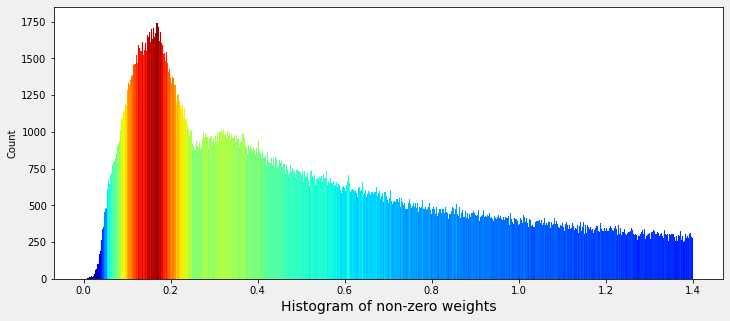

In [ ]:
#collapse-hide
fig,ax = plt.subplots(figsize = (12,5), facecolor="#F0F0F0")
sns.histplot(
    ax=ax,
    x=train_df['weight'], 
    bins=1400, 
    kde_kws={"clip":(0.001,1.4)}, 
    binrange=(0.001,1.4),
    color='darkcyan', 
    kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of non-zero weights", size=14)
plt.show();
del values
gc.collect();

https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance

# HyperParameters

# Data

## Loading training data

In [ ]:
train_df = train_df.query('date > 85').reset_index(drop=True)
# limit memory usage
train_df = train_df.astype({c: np.float32
    for c in train_df.select_dtypes(include='float64').columns})
train_df.fillna(train_df.mean(), inplace=True)
train_df = train_df.query('weight > 0').reset_index(drop = True)
train_df['action'] = ((train_df['resp_1'] > 0.00001) &
                      (train_df['resp_2'] > 0.00001) &
                      (train_df['resp_3'] > 0.00001 ) &
                      (train_df['resp_4'] > 0.00001 ) &
                      (train_df['resp'] > 0.00001 )).astype('int')

features = [c for c in train_df.columns if 'feature' in c]
resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']

x_train = train_df[features].values
y_train = np.stack([(train_df[col] > 0.000001).astype('int') 
                        for col in resp_cols]).T # Multitarget
                        
f_mean = np.mean(train_df[features[1:]].values, axis=0)

# Model

The idea of using an encoder is the denoise the data. After many attempts at using a unsupervised autoencoder, the choice landed on a bottleneck encoder as this will preserve the intra-feature relations.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

In [ ]:
#collapse-show
# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
#collapse-show
class CVTuner(kt.engine.tuner.Tuner):
    def run_trial(self, trial, X, y, splits, batch_size=32, epochs=1,callbacks=None):
        val_losses = []
        for train_indices, test_indices in splits:
            X_train, X_test = [x[train_indices] for x in X], [x[test_indices] for x in X]
            y_train, y_test = [a[train_indices] for a in y], [a[test_indices] for a in y]
            if len(X_train) < 2:
                X_train = X_train[0]
                X_test = X_test[0]
            if len(y_train) < 2:
                y_train = y_train[0]
                y_test = y_test[0]
            
            model = self.hypermodel.build(trial.hyperparameters)
            hist = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      epochs=epochs,
                        batch_size=batch_size,
                      callbacks=callbacks)
            
            val_losses.append([hist.history[k][-1] for k in hist.history])
        val_losses = np.asarray(val_losses)
        self.oracle.update_trial(trial.trial_id, {k:np.mean(val_losses[:,i]) for i,k in enumerate(hist.history.keys())})
        self.save_model(trial.trial_id, model)

## Building the autoencoder

The autoencoder should aid in denoising the data based on [this](https://www.semanticscholar.org/paper/Deep-Bottleneck-Classifiers-in-Supervised-Dimension-Parviainen/fb86483f7573f6430fe4597432b0cd3e34b16e43) paper.

In [ ]:
def build_autoencoder(input_dim, output_dim, noise=.05):
    inputs = tf.keras.layers.Input(input_dim)
    encoded = tf.keras.layers.BatchNormalization()(inputs)
    encoded = tf.keras.layers.GaussianNoise(noise)(encoded)
    encoded = tf.keras.layers.Dense(640, activation='relu')(encoded)
    decoded = tf.keras.layers.Dropout(0.2)(encoded)
    decoded = tf.keras.layers.Dense(input_dim, name='decoded')(decoded)
    x = tf.keras.layers.Dense(320, activation='relu')(decoded)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(output_dim, activation='sigmoid',
                              name='label_output')(x)

    encoder = tf.keras.models.Model(inputs=inputs, outputs=encoded)

    autoencoder = tf.keras.models.Model(inputs=inputs, outputs=[decoded,x])
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                        loss={'decoded':'mse',
                              'label_output':'binary_crossentropy'})
    return autoencoder, encoder

## Building the MLP

In [ ]:
def build_model(hp, input_dim, output_dim, encoder):
    inputs = tf.keras.layers.Input(input_dim)
    
    x = encoder(inputs)
    
    x = tf.keras.layers.Concatenate()([x,inputs]) #use both raw and encoded features
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(hp.Float('init_dropout',0.0,0.5))(x)
    
    for i in range(hp.Int('num_layers',1,5)):
        x = tf.keras.layers.Dense(hp.Int('num_units_{i}',128,256))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Lambda(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(hp.Float(f'dropout_{i}',0.0,0.5))(x)

    x = tf.keras.layers.Dense(output_dim,activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=x)

    model.compile(optimizer = tf.keras.optimizers.Adam(
                    hp.Float('lr',0.00001,0.1,default=0.001)),
                  loss = tf.keras.losses.BinaryCrossentropy(
                    label_smoothing = hp.Float('label_smoothing',0.0,0.1)),
                  metrics = [tf.keras.metrics.AUC(name = 'auc')])
    return model

## Building a model

We add gaussian noise with mean and std from training datea. After training we lock the layersfin the encoder from further training.

# Optimizer

# Callbacks

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1)
    ]

## Training

In [ ]:
#with strategy.scope():
autoencoder,encoder = build_autoencoder(
    x_train.shape[-1], y_train.shape[-1], noise=.1)

In [ ]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 130)               520       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 130)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 640)               83840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 640)               0         
_________________________________________________________________
decoded (Dense)              (None, 130)               83330     
_________________________________________________________________
dense_5 (Dense)              (None, 320)               4192

In [ ]:
#collapse-output
history = autoencoder.fit(
    x_train,
    (x_train, y_train),
    epochs=1002,
    batch_size=16384,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/1002
87/87 [==============================] - 6s 37ms/step - loss: 3.2765 - decoded_loss: 2.5013 - label_output_loss: 0.7752 - val_loss: 1.1174 - val_decoded_loss: 0.4225 - val_label_output_loss: 0.6949
Epoch 2/1002
87/87 [==============================] - 3s 30ms/step - loss: 1.1679 - decoded_loss: 0.4596 - label_output_loss: 0.7083 - val_loss: 0.8400 - val_decoded_loss: 0.1500 - val_label_output_loss: 0.6899
Epoch 3/1002
87/87 [==============================] - 3s 29ms/step - loss: 1.0435 - decoded_loss: 0.3474 - label_output_loss: 0.6961 - val_loss: 0.7875 - val_decoded_loss: 0.0986 - val_label_output_loss: 0.6889
Epoch 4/1002
87/87 [==============================] - 2s 29ms/step - loss: 0.9867 - decoded_loss: 0.2949 - label_output_loss: 0.6918 - val_loss: 0.7706 - val_decoded_loss: 0.0816 - val_label_output_loss: 0.6890
Epoch 5/1002
87/87 [==============================] - 3s 29ms/step - loss: 1.0088 - decoded_loss: 0.3185 - label_output_loss: 0.6903 - val_loss: 0.7628 - va

In [ ]:
encoder.save_weights('encoder.hdf5')

In [ ]:
encoder.trainable = False

## Running CV
Following [this notebook](https://www.kaggle.com/gogo827jz/jane-street-ffill-xgboost-purgedtimeseriescv) which use 5 `PurgedGroupTimeSeriesSplit` split on the dates in the training data.

We add the locked encoder as the first layer of the MLP. This seems to help in speeding up the submission rather than first predicting using the encoder then using the MLP.

We use a Baysian Optimizer to find the optimal HPs for out model. 20 trials take about 2 hours on GPU.

In [ ]:
#hide
#https://medium.com/@micwurm/using-tensorflow-lite-to-speed-up-predictions-a3954886eb98

class LiteModel:
    
    @classmethod
    def from_file(cls, model_path):
        return LiteModel(tf.lite.Interpreter(model_path=model_path))
    
    @classmethod
    def from_keras_model(cls, kmodel):
        converter = tf.lite.TFLiteConverter.from_keras_model(kmodel)
        tflite_model = converter.convert()
        return LiteModel(tf.lite.Interpreter(model_content=tflite_model))
    
    def __init__(self, interpreter):
        self.interpreter = interpreter
        self.interpreter.allocate_tensors()
        input_det = self.interpreter.get_input_details()[0]
        output_det = self.interpreter.get_output_details()[0]
        self.input_index = input_det["index"]
        self.output_index = output_det["index"]
        self.input_shape = input_det["shape"]
        self.output_shape = output_det["shape"]
        self.input_dtype = input_det["dtype"]
        self.output_dtype = output_det["dtype"]
        
    def predict(self, inp):
        inp = inp.astype(self.input_dtype)
        count = inp.shape[0]
        out = np.zeros((count, self.output_shape[1]), dtype=self.output_dtype)
        for i in range(count):
            self.interpreter.set_tensor(self.input_index, inp[i:i+1])
            self.interpreter.invoke()
            out[i] = self.interpreter.get_tensor(self.output_index)[0]
        return out
    
    def predict_single(self, inp):
        """ Like predict(), but only for a single record. The input data can be a Python list. """
        inp = np.array([inp], dtype=self.input_dtype)
        self.interpreter.set_tensor(self.input_index, inp)
        self.interpreter.invoke()
        out = self.interpreter.get_tensor(self.output_index)
        return out[0]

In [ ]:
model_fn = lambda hp: build_model(
    hp, x_train.shape[-1], y_train.shape[-1], encoder)